In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix


In [2]:
class EMGClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.2):
        super(EMGClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_sizes[1]),
            # nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_sizes[2]),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[2], num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)


In [3]:
df = pd.read_csv('processed_data/onset_feature_train.csv')
feature_set = 'ch'
# feature_set = 'ch'
X = df.filter(regex=feature_set, axis=1)
y_train = df['label'].to_numpy()

In [4]:
test_df = pd.read_csv('processed_data/onset_feature_test.csv')
Xtest = test_df.filter(regex=feature_set, axis=1).to_numpy()
y_test = test_df['label'].to_numpy()

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(Xtest)

/home/alexiswu/2023Fall/NeuroTech/neurotech/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [6]:
hidden_sizes = [128,64,32]
batch_size = 64
num_epochs = 150
lr = 0.01
input_size = X_train.shape[1]  # Number of features
num_classes = len(set(y_train))  # Number of classes
model = EMGClassifier(input_size, hidden_sizes, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [7]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Train the model
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    # Forward pass: Compute predicted y by passing x to the model
    for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        if (i+1) % (len(train_dataset) // batch_size) == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    scheduler.step()
    losses.append(epoch_loss)


/home/alexiswu/2023Fall/NeuroTech/neurotech/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/150], Step [23/24], Loss: 1.1168
Epoch [2/150], Step [23/24], Loss: 0.9977
Epoch [3/150], Step [23/24], Loss: 0.7572
Epoch [4/150], Step [23/24], Loss: 0.8686
Epoch [5/150], Step [23/24], Loss: 0.8358
Epoch [6/150], Step [23/24], Loss: 0.7078
Epoch [7/150], Step [23/24], Loss: 0.6896
Epoch [8/150], Step [23/24], Loss: 1.1520
Epoch [9/150], Step [23/24], Loss: 0.6127
Epoch [10/150], Step [23/24], Loss: 0.6591
Epoch [11/150], Step [23/24], Loss: 0.5772
Epoch [12/150], Step [23/24], Loss: 0.7375
Epoch [13/150], Step [23/24], Loss: 0.5925
Epoch [14/150], Step [23/24], Loss: 0.6040
Epoch [15/150], Step [23/24], Loss: 0.5271
Epoch [16/150], Step [23/24], Loss: 0.4330
Epoch [17/150], Step [23/24], Loss: 0.7741
Epoch [18/150], Step [23/24], Loss: 0.6453
Epoch [19/150], Step [23/24], Loss: 0.4783
Epoch [20/150], Step [23/24], Loss: 0.5367
Epoch [21/150], Step [23/24], Loss: 0.4503
Epoch [22/150], Step [23/24], Loss: 0.4313
Epoch [23/150], Step [23/24], Loss: 0.5876
Epoch [24/150], Step

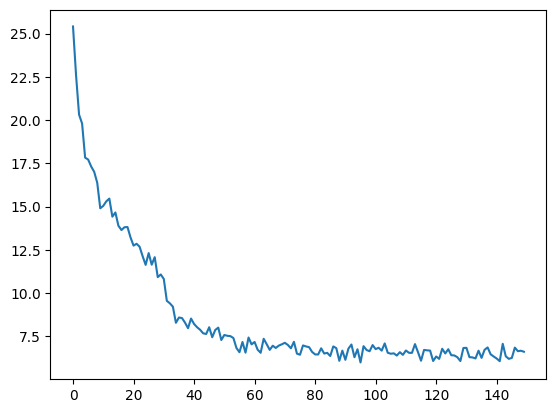

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [10]:

# Evaluate the model
model.eval()  # Set the model to evaluation mode
preds = []
actual = []
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    preds.append(predicted)
    actual.append(y_test_tensor)
    total += y_test_tensor.size(0)
    correct += (predicted == y_test_tensor).sum().item()
    

print('Accuracy of the model on the test set: {} %'.format(100 * correct / total))
f1 = f1_score(y_test_tensor, predicted, average=None)
cm = confusion_matrix(y_test_tensor, predicted,labels=[0,1,2])
print(f"f1 score: {f1}")
print(f"confusion matrix:\n {cm}")

Accuracy of the model on the test set: 80.4177545691906 %
f1 score: [0.8        0.83265306 0.7816092 ]
confusion matrix:
 [[104   9  17]
 [  9 102  14]
 [ 17   9 102]]


In [12]:
torch.save(model.state_dict(), 'models/MLP.pth')

In [13]:
import joblib
joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']